# COVID-19 Auswertung - new cases, deaths, Intensivstationen
## DIVI und WHO Daten - Deutschland und einige Nachbarn


## import libraries

In [468]:
import pandas as pd #Daten
from matplotlib import pyplot as plt # plots
#import matplotlib as mpl
from matplotlib.ticker import FuncFormatter   # Numberformat plot ticks
import numpy as np

# performance
from datetime import datetime
from datetime import date # todays date
import seaborn as sns

import os
now = datetime.now()

# Preprocessing Dataframes

## Datenimport

In [469]:
# Webabruf - CSV einlesen
data = pd.read_csv("https://covid19.who.int/WHO-COVID-19-global-data.csv")

# Lokal - CSV einlesen
#df = pd.read_csv("D:\Github\Covid-19-Auswertung-WHO-DIVI\data-WvhXR.csv")

# Lokal - CSV einlesen
df_divi2 = pd.read_csv("D:\\Github\\Covid-19-Auswertung-WHO-DIVI\\input\\data-k3LbD.csv")
df_divi2['date'] = pd.to_datetime(df_divi2.date, utc=True)
#df_divi2 = df.loc[df.date >= ts, :]

# Lokal CSV einlesen - Testzahlen
df_PQ = pd.read_excel("D:\\Github\\Covid-19-Auswertung-WHO-DIVI\\input\\Testzahlen-gesamt.xlsx",
                    sheet_name ="Testzahlen",
                    usecols="B:F",
                    skiprows=2,)

In [470]:
#df_PQ

### preprocessing

In [471]:
#gleitender Mittelwert der cases und deaths, 7 Tage
data['MA'] = data['New_cases'].rolling(window=7,min_periods=1).mean()
data['MA_deaths'] = data['New_deaths'].rolling(window=7, min_periods=1).mean()

data['MSTD_cases'] = data['New_cases'].rolling(window=7,min_periods=1).std()
data['MSTD_deaths'] = data['New_deaths'].rolling(window=7,min_periods=1).std()

data['OTG_cases'] = data['MA'] + data['MSTD_cases']
data['UTG_cases'] = data['MA'] - data['MSTD_cases']

data['OTG_deaths'] = data['MA_deaths'] + data['MSTD_deaths']
data['UTG_deaths'] = data['MA_deaths'] - data['MSTD_deaths']

# Date_reported in eine Datumsspalte umwandeln
data['Date_reported'] = pd.to_datetime(data.Date_reported, utc=True)

# df['date'] = pd.to_datetime(df.date, utc=True)

#Timestamp definieren  YYYY-MM-DD
ts = pd.to_datetime('2020-10-01', utc=True)

#dataframe reduzieren 
data = data.loc[data.Date_reported >= ts, :]
df_divi2 = df_divi2.loc[df_divi2.date >= ts, :]
# df = df.loc[df.date >= ts, :]

# preprocessing Positivenquote

del df_PQ["Anzahl übermittelnde Labore"]
del df_PQ["Positiven-quote (%)"]


df_PQ = df_PQ.replace('\*','',regex=True)
df_PQ.drop(df_PQ.tail(2).index,inplace=True) # drop last n rows
df_PQ.drop(df_PQ.head(1).index,inplace=True) # drop last n rows
#df_PQ["Positiven-quote (%)"] = df_PQ["Positiven-quote (%)"].astype(str)+ " %"
df_PQ["Kalenderwoche 2020"] = "KW "+df_PQ["Kalenderwoche 2020"].astype(str)

df_PQ["Positivenquote"] = round(100*(df_PQ["Positiv getestet"]/df_PQ["Anzahl Testungen"]),1)

df_PQ.head(1)


,Kalenderwoche 2020,Anzahl Testungen,Positiv getestet,Positivenquote
1,KW 11,127457.0,7582.0,5.9


### Länder definieren

In [472]:
ger = data[data.Country == 'Germany']
fr = data[data.Country == 'France']
at = data[data.Country == 'Austria']
pl = data[data.Country == 'Poland']
cz = data[data.Country == 'Czechia']
ch = data[data.Country == 'Switzerland']
it = data[data.Country == 'Italy']
es = data[data.Country == 'Spain']
gb = data[data.Country == 'The United Kingdom']
se = data[data.Country == 'Sweden']

# Variablen für die Plots definieren

### Linien und Schriftgrößen

In [473]:
# Linien Stärke
lws = 3
lwb = 7
# Bezugsschriftgröße
size = 28

### Einwohnerzahlen

In [550]:
E_fr = 66012908
E_pl = 38659927
E_ger = 83020000
E_cz = 10586651
E_at = 8902600
E_ch = 8847020
E_gb = 66650000

 ### Bezugsgröße Einwohner und Datum

In [475]:
pE = 100000

# Heutiges Datum und formatieren dd.mm.YYYY
today = date.today().strftime("%d.%m.%Y")

### Speicherorte und Dateinamen

In [476]:
pfad = "D:\\Github\\Covid-19-Auswertung-WHO-DIVI\\output\\"

name_1_1 = "plot_1-1_cases_absolute numbers.png" # cases absoulte zahlen EU
name_1_2 = "plot_1-2_cases.png" # cases pro 100.000 Einwohner EU 
name_2 = "plot_2_intensiv.png" # intensiv Deutschland
name_2_2 = "plot_2_2_intensiv2.png" # intensiv Deutschland
name_3_1 = "plot_3-1_deaths_absolute numbers.png" # deaths absolute zahlen EU
name_3_2 = "plot_3-2_deaths.png" # deaths pro 100.000 Einwohner EU
name_4_1 = "plot_4-1_cases_ger.png" # cases Deutschland
name_4_2 = "plot_4-2_deaths_ger.png" # deaths Deutschland
name_5 = "performance_dist_plot.png" # Performance Plot
name_6 = "plot_6_Positivenquote_ger.png" # Positivenquote
name_6_2 = "plot_6-2_Anzahl_Testungen_ger.png" # Anzahl Testungen
name_7 = "plot_7_Impfquote_ger.png" # Impfquote Deutschland Bundesländer

## Länder Farben

In [477]:
c_fr = '#f80d0d'    # rot
c_pl = '#25e5e5'    # cyan
c_ger = '#0721ff'   # dunkelblau
c_cz = '#bb8fce'    # lila
c_at = '#18c213'    # grün
c_ch = '#000000'    # schwarz
c_gb = '#faac2b'    # orange

# Visualisierung der Plots

### 1-1) Neue Fälle 7 Tage Mittelwert (absolute Zahlen)

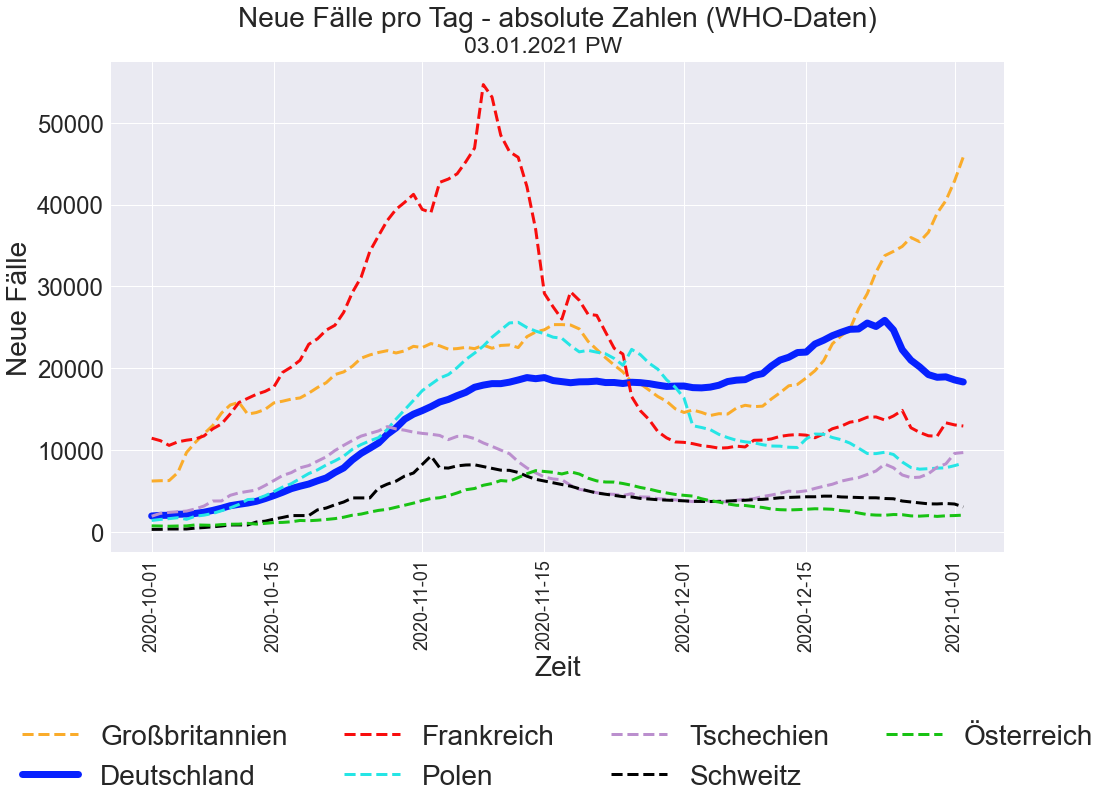

In [478]:
# Größe im 16:9 format und mit Umrechnungsfaktor 1.2 (durch Test ermittelt) für PowerPoint angepasst
plt.figure(figsize=(16,9))

plt.style.use('seaborn')

# Neue Fälle pro Tag pro 100.000 Einwohner - 02.12.2020 

plt.plot(gb.Date_reported,gb['MA'], color=c_gb, linestyle = 'dashed', linewidth = lws, label="Großbritannien")
plt.plot(ger.Date_reported,ger['MA'], color=c_ger, linestyle = 'solid', linewidth = lwb, label="Deutschland")
plt.plot(fr.Date_reported,fr['MA'], color=c_fr, linestyle = 'dashed', linewidth = lws, label="Frankreich")
plt.plot(pl.Date_reported,pl['MA'], color=c_pl, linestyle = 'dashed', linewidth = lws, label="Polen")
plt.plot(cz.Date_reported,cz['MA'], color=c_cz, linestyle = 'dashed', linewidth = lws, label="Tschechien")
plt.plot(ch.Date_reported,ch['MA'], color=c_ch, linestyle = 'dashed', linewidth = lws, label="Schweitz")
plt.plot(at.Date_reported,at['MA'], color=c_at, linestyle = 'dashed', linewidth = lws, label="Österreich")

plt.legend(loc='upper center', 
           bbox_to_anchor=(0.5, -0.3),
           fancybox=True, 
           shadow=True, 
           ncol=4, 
           fontsize=size)

# Schriftgrößen x und y achsenwerte
plt.xticks(fontsize=size - 10, rotation=90)
plt.yticks(fontsize=size -4)

plt.ylabel('Neue Fälle', fontsize=size)
plt.xlabel('Zeit', fontsize=size)

plt.title('Neue Fälle pro Tag - absolute Zahlen (WHO-Daten)\n', fontsize=size)
plt.suptitle(today + ' PW', fontsize=size-5, y=0.92)

# Diagramm als Bild exporieren und Auflösung definieren
plt.savefig(pfad + name_1_1, dpi = 150, bbox_inches='tight')
#plt.close()

### 1-2) Neue Fälle 7 Tage Mittelwert (pro 100.000 Einwohner)

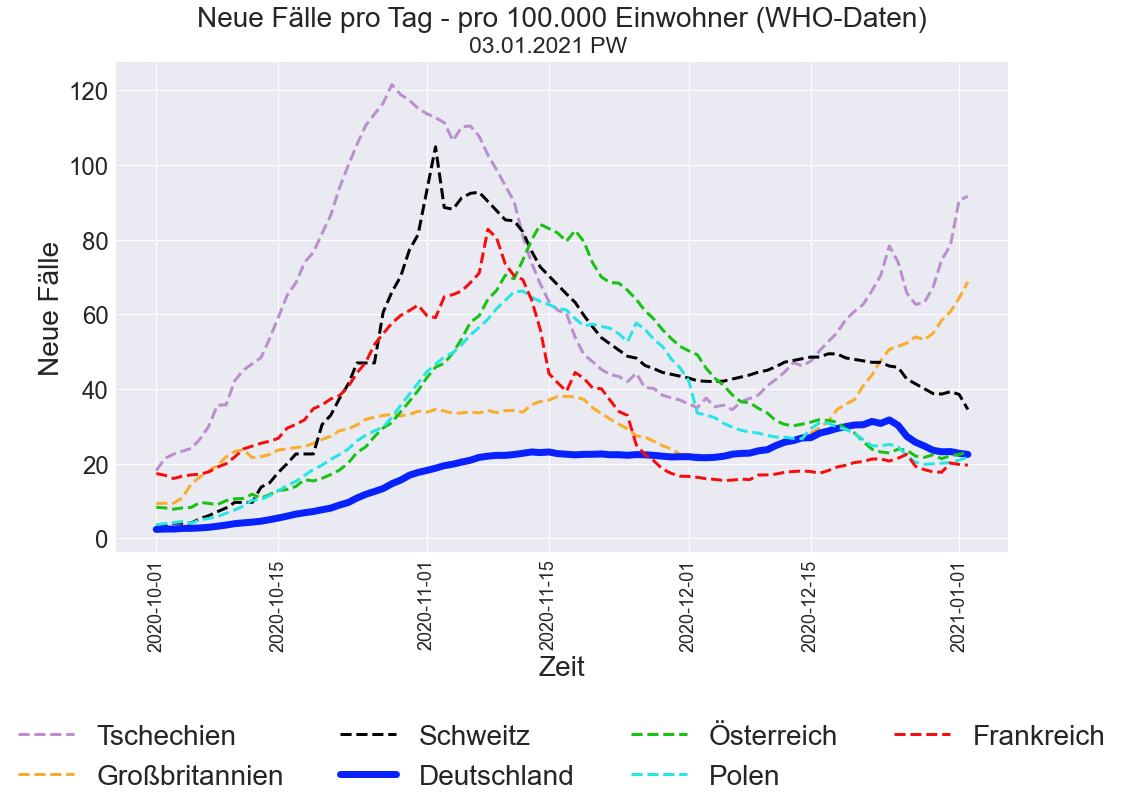

In [479]:
# Größe im 16:9 format und mit Umrechnungsfaktor 1.2 (durch Test ermittelt) für PowerPoint angepasst
plt.figure(figsize=(16,9))

plt.style.use('seaborn')


# Neue Fälle pro Tag pro 100.000 Einwohner - 02.12.2020 

plt.plot(cz.Date_reported,cz['MA']* (pE/E_cz), color=c_cz, linestyle = 'dashed', linewidth = lws, label="Tschechien")
plt.plot(gb.Date_reported,gb['MA']* (pE/E_gb), color=c_gb, linestyle = 'dashed', linewidth = lws, label="Großbritannien")
plt.plot(ch.Date_reported,ch['MA']* (pE/E_ch), color=c_ch, linestyle = 'dashed', linewidth = lws, label="Schweitz")
plt.plot(ger.Date_reported,ger['MA']* (pE/E_ger), color=c_ger, linestyle = 'solid', linewidth = lwb, label="Deutschland")
plt.plot(at.Date_reported,at['MA']* (pE/E_at), color=c_at, linestyle = 'dashed', linewidth = lws, label="Österreich")
plt.plot(pl.Date_reported,pl['MA']* (pE/E_pl), color=c_pl, linestyle = 'dashed', linewidth = lws, label="Polen")
plt.plot(fr.Date_reported,fr['MA']* (pE/E_fr), color=c_fr, linestyle = 'dashed', linewidth = lws, label="Frankreich")

plt.legend(loc='upper center', 
           bbox_to_anchor=(0.5, -0.3),
           fancybox=True, 
           shadow=True, 
           ncol=4, 
           fontsize=size)


# Schriftgrößen x und y achsenwerte
plt.xticks(fontsize=size - 10, rotation=90)
plt.yticks(fontsize=size -4)

plt.ylabel('Neue Fälle', fontsize=size)
plt.xlabel('Zeit', fontsize=size)

plt.title('Neue Fälle pro Tag - pro 100.000 Einwohner (WHO-Daten)\n', fontsize=size)
plt.suptitle(today + ' PW', fontsize=size-5, y=0.92)

# Diagramm als Bild exporieren und Auflösung definieren
plt.savefig(pfad + name_1_2, dpi = 150, bbox_inches='tight')
# plt.close()

### 2-2) Intensivstationen DIVI2

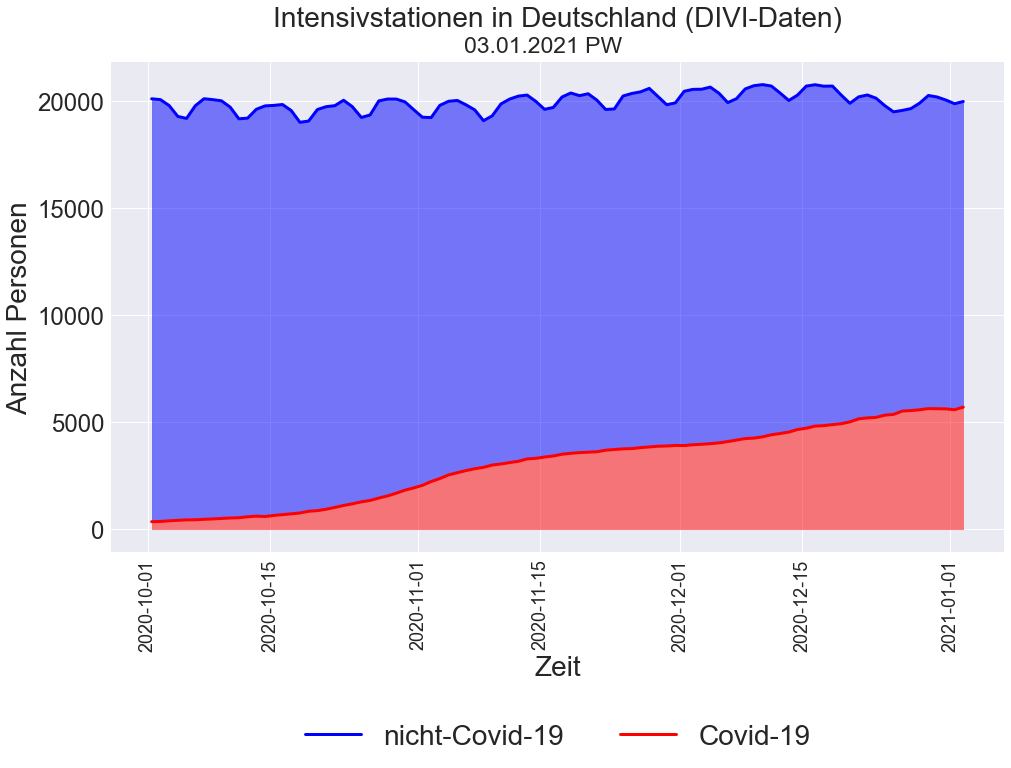

In [480]:
# Größe im 16:9 format und mit Umrechnungsfaktor 1.2 (durch Test ermittelt) für PowerPoint angepasst
plt.figure(figsize=(16,9))

plt.style.use('seaborn')
plt.grid(True)
plt.plot(df_divi2.date,df_divi2['Belegte Betten'], color = 'blue', linewidth = lws, label = "nicht-Covid-19")
plt.plot(df_divi2.date,df_divi2['COVID-19-Fälle'], color = 'red', linewidth = lws, label = "Covid-19")


plt.legend(loc='upper center', 
           bbox_to_anchor=(0.5, -0.3),
           fancybox=True, 
           shadow=True, 
           ncol=2, 
           fontsize=size)

# Schriftgrößen x und y achsenwerte
plt.xticks(fontsize=size - 10, rotation = 90)
plt.yticks(fontsize=size -4)

# plt.xticks([])
plt.ylabel('Anzahl Personen', fontsize=size)
plt.xlabel('Zeit', fontsize=size)
#plt.title('DIVI-Intensivregister (www.intensivregister.de)  \n Stand: ' + today, fontsize=size)

plt.title('Intensivstationen in Deutschland (DIVI-Daten)\n', fontsize=size)
plt.suptitle(today + ' PW', fontsize=size-5, y=0.92)

# fill area between 
plt.fill_between(df_divi2.date, df_divi2['COVID-19-Fälle'], color='red',alpha=0.5)
plt.fill_between(df_divi2.date, df_divi2['COVID-19-Fälle'], df_divi2['Belegte Betten'], color='blue',alpha=0.5)

# Diagramm als Bild exporieren und Auflösung definieren
plt.savefig(pfad + name_2_2, dpi = 150, bbox_inches='tight')
plt.show()
plt.close()

###  3-1) Todesfälle 7 Tage Mittelwert (absolute Zahlen) 

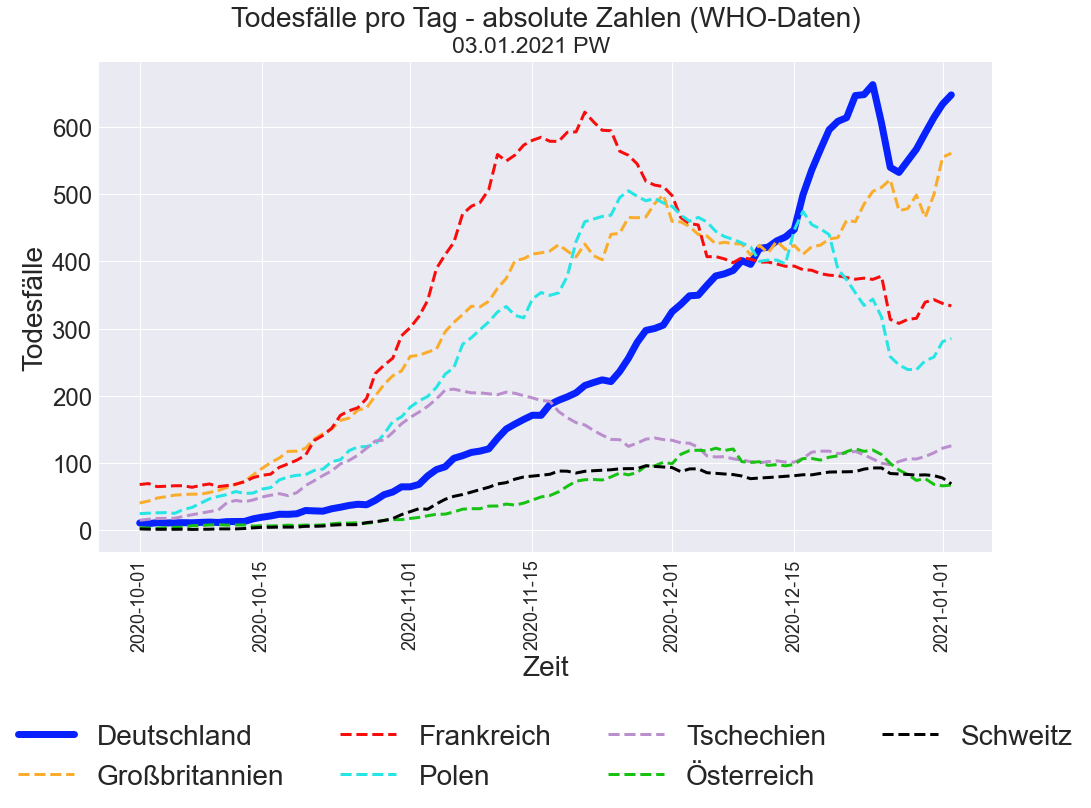

In [481]:
# Größe im 16:9 format und mit Umrechnungsfaktor 1.2 (durch Test ermittelt) für PowerPoint angepasst
plt.figure(figsize=(16,9))

plt.style.use('seaborn')
plt.grid(True)

# Todesfälle pro 100.000 Einwohner 02.12.2020
plt.plot(ger.Date_reported,ger['MA_deaths'], color=c_ger, linestyle = 'solid', linewidth = lwb, label = "Deutschland") # blau, linie, dick
plt.plot(gb.Date_reported,gb['MA_deaths'], color=c_gb, linestyle = 'dashed', linewidth = lws, label = "Großbritannien") # gelb, gestrichelt, dünn
plt.plot(fr.Date_reported,fr['MA_deaths'], color=c_fr, linestyle = 'dashed', linewidth = lws, label = "Frankreich") # rot, gestrichelt, dünn
plt.plot(pl.Date_reported,pl['MA_deaths'], color=c_pl, linestyle = 'dashed', linewidth = lws, label = "Polen") # cyan, gestrichelt, dünn
plt.plot(cz.Date_reported,cz['MA_deaths'], color=c_cz, linestyle = 'dashed', linewidth = lws, label = "Tschechien") # magenta, gestrichelt, dünn
plt.plot(at.Date_reported,at['MA_deaths'], color=c_at, linestyle = 'dashed', linewidth = lws, label = "Österreich") # grün, gestrichelt, dünn
plt.plot(ch.Date_reported,ch['MA_deaths'], color=c_ch, linestyle = 'dashed', linewidth = lws, label = "Schweitz") # schwarz, gestrichelt, dünn

# Legende 
plt.legend(loc='upper center', 
           bbox_to_anchor=(0.5, -0.3),
           fancybox=True, 
           shadow=True, 
           ncol=4, 
           fontsize=size)

# Schriftgrößen x und y achsenwerte
plt.xticks(fontsize=size - 10, rotation = 90)
plt.yticks(fontsize=size -4)
plt.ylabel('Todesfälle', fontsize=size)
plt.xlabel('Zeit', fontsize=size)

plt.title('Todesfälle pro Tag - absolute Zahlen (WHO-Daten)\n', fontsize=size)
plt.suptitle(today + ' PW', fontsize=size-5, y=0.92)


# Diagramm als Bild exporieren und Auflösung definieren
plt.savefig(pfad + name_3_1, dpi = 150, bbox_inches='tight')
# plt.close()

###  3-2) Todesfälle 7 Tage Mittelwert (pro 100.000 Einwohner) 

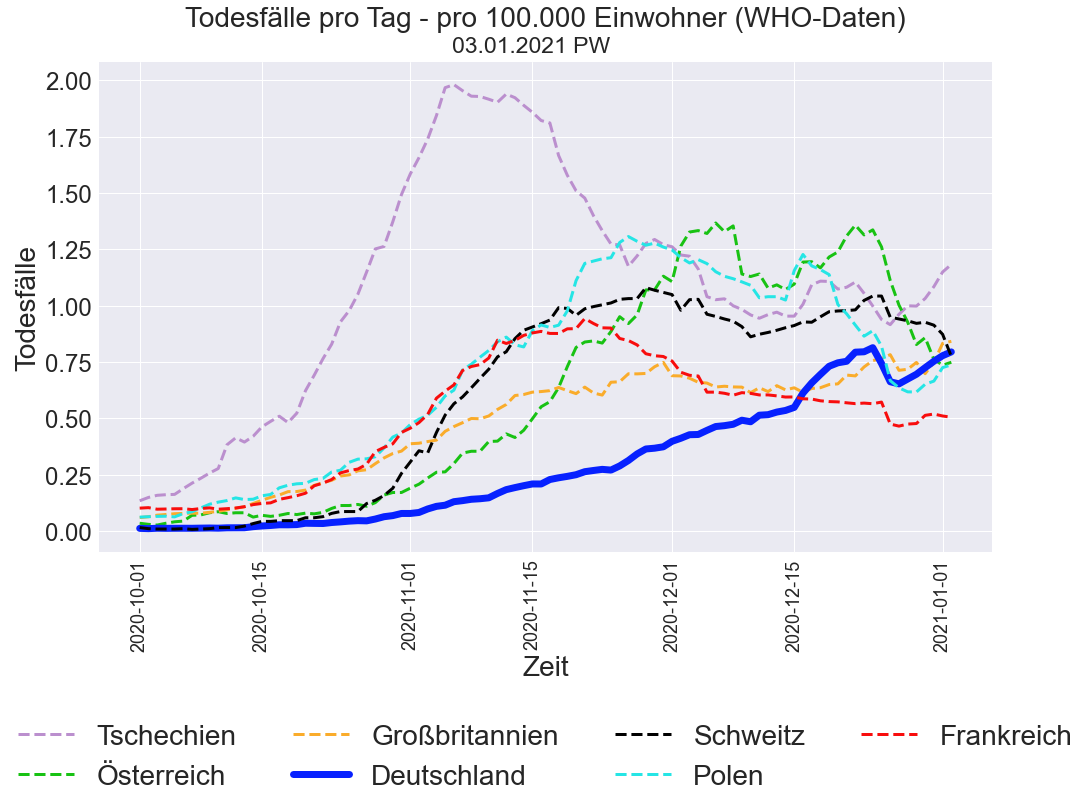

In [482]:
# Größe im 16:9 format und mit Umrechnungsfaktor 1.2 (durch Test ermittelt) für PowerPoint angepasst
plt.figure(figsize=(16,9))

plt.style.use('seaborn')
plt.grid(True)

# Todesfälle pro 100.000 Einwohner 02.12.2020

plt.plot(cz.Date_reported,cz['MA_deaths'] * (pE/E_cz), color=c_cz, linestyle = 'dashed', linewidth = lws, label = "Tschechien") # magenta, gestrichelt, dünn
plt.plot(at.Date_reported,at['MA_deaths'] * (pE/E_at), color=c_at, linestyle = 'dashed', linewidth = lws, label = "Österreich") # grün, gestrichelt, dünn
plt.plot(gb.Date_reported,gb['MA_deaths'] * (pE/E_gb), color=c_gb, linestyle = 'dashed', linewidth = lws, label = "Großbritannien") # gelb, gestrichelt, dünn
plt.plot(ger.Date_reported,ger['MA_deaths'] * (pE/E_ger), color=c_ger, linestyle = 'solid', linewidth = lwb, label = "Deutschland") # blau, linie, dick
plt.plot(ch.Date_reported,ch['MA_deaths'] * (pE/E_ch), color=c_ch, linestyle = 'dashed', linewidth = lws, label = "Schweitz") # schwarz, gestrichelt, dünn
plt.plot(pl.Date_reported,pl['MA_deaths'] * (pE/E_pl), color=c_pl, linestyle = 'dashed', linewidth = lws, label = "Polen") # cyan, gestrichelt, dünn
plt.plot(fr.Date_reported,fr['MA_deaths'] * (pE/E_fr), color=c_fr, linestyle = 'dashed', linewidth = lws, label = "Frankreich") # rot, gestrichelt, dünn


# Legende 
plt.legend(loc='upper center', 
           bbox_to_anchor=(0.5, -0.3),
           fancybox=True, 
           shadow=True, 
           ncol=4, 
           fontsize=size)

# Schriftgrößen x und y achsenwerte
plt.xticks(fontsize=size - 10, rotation = 90)
plt.yticks(fontsize=size -4)
plt.ylabel('Todesfälle', fontsize=size)
plt.xlabel('Zeit', fontsize=size)

plt.title('Todesfälle pro Tag - pro 100.000 Einwohner (WHO-Daten)\n', fontsize=size)
plt.suptitle(today + ' PW', fontsize=size-5, y=0.92)

# Diagramm als Bild exporieren und Auflösung definieren
plt.savefig(pfad + name_3_2, dpi = 150, bbox_inches='tight')
#plt.close()

In [483]:
# ts = pd.to_datetime('2020-12-15', utc=True)
# #dataframe reduzieren 
# data = data.loc[data.Date_reported >= ts, :]
# ger = data[data.Country == 'Germany']

###  4-1) Cases 7 Tage Mittelwert Deutschland

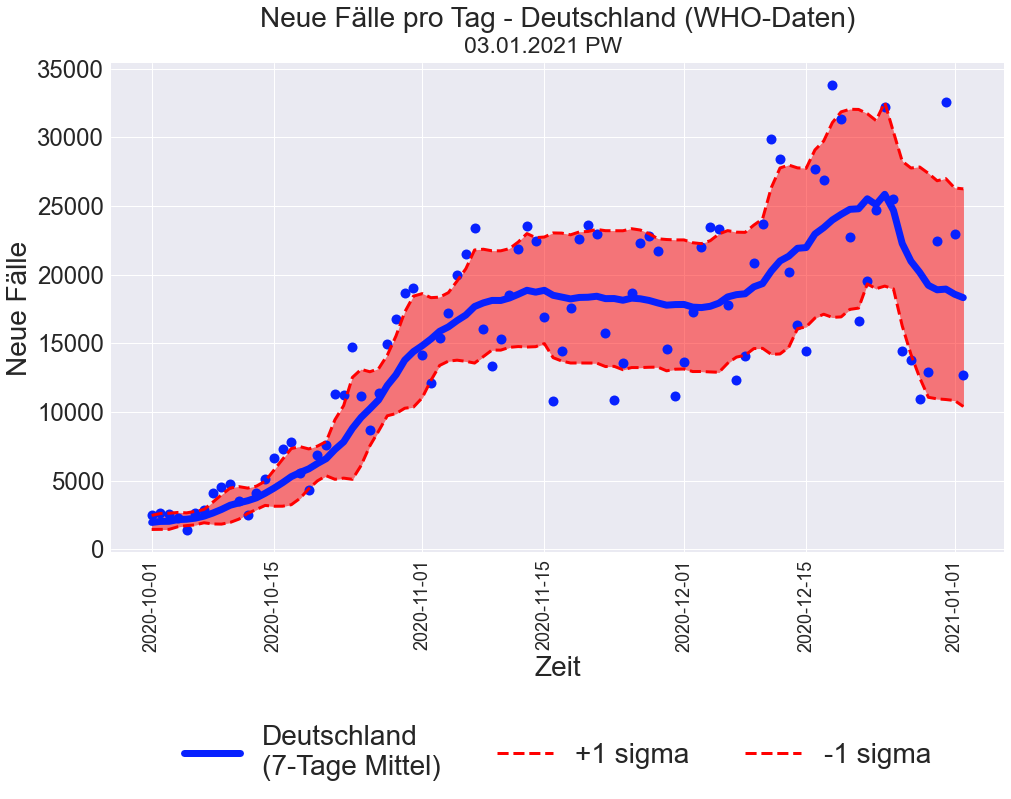

In [484]:
# Größe im 16:9 format und mit Umrechnungsfaktor 1.2 (durch Test ermittelt) für PowerPoint angepasst
plt.figure(figsize=(16,9))

# Neue Fälle pro Tag pro 100.000 Einwohner - 02.12.2020 
plt.plot(ger.Date_reported,ger['MA'], color=c_ger, linestyle = 'solid', linewidth = lwb, label = "Deutschland\n(7-Tage Mittel)")
plt.plot(ger.Date_reported,ger['New_cases'], marker='.', linestyle='', color=c_ger, markersize = 20)
plt.plot(ger.Date_reported,ger['OTG_cases'], color='red', linestyle = 'dashed', linewidth = lws, label ="+1 sigma")
plt.plot(ger.Date_reported,ger['UTG_cases'], color='red', linestyle = 'dashed', linewidth = lws, label ="-1 sigma")

plt.legend(loc='upper center', 
           bbox_to_anchor=(0.5, -0.3),
           fancybox=True, 
           shadow=True, 
           ncol=3, 
           fontsize=size)

# Schriftgrößen x und y achsenwerte
plt.xticks(fontsize=size - 10, rotation = 90)
plt.yticks(fontsize=size -4)

plt.ylabel('Neue Fälle', fontsize=size)
plt.xlabel('Zeit', fontsize=size)

plt.title('Neue Fälle pro Tag - Deutschland (WHO-Daten)\n', fontsize=size)
plt.suptitle(today + ' PW', fontsize=size-5, y=0.92)

# fill area between lines
plt.fill_between(ger.Date_reported, ger['OTG_cases'], ger['UTG_cases'] , color='red',alpha=0.5)

# Diagramm als Bild exporieren und Auflösung definieren
plt.savefig(pfad + name_4_1, dpi = 150, bbox_inches='tight')
#plt.close()

###  4-2) Deaths 7 Tage Mittelwert Deutschland

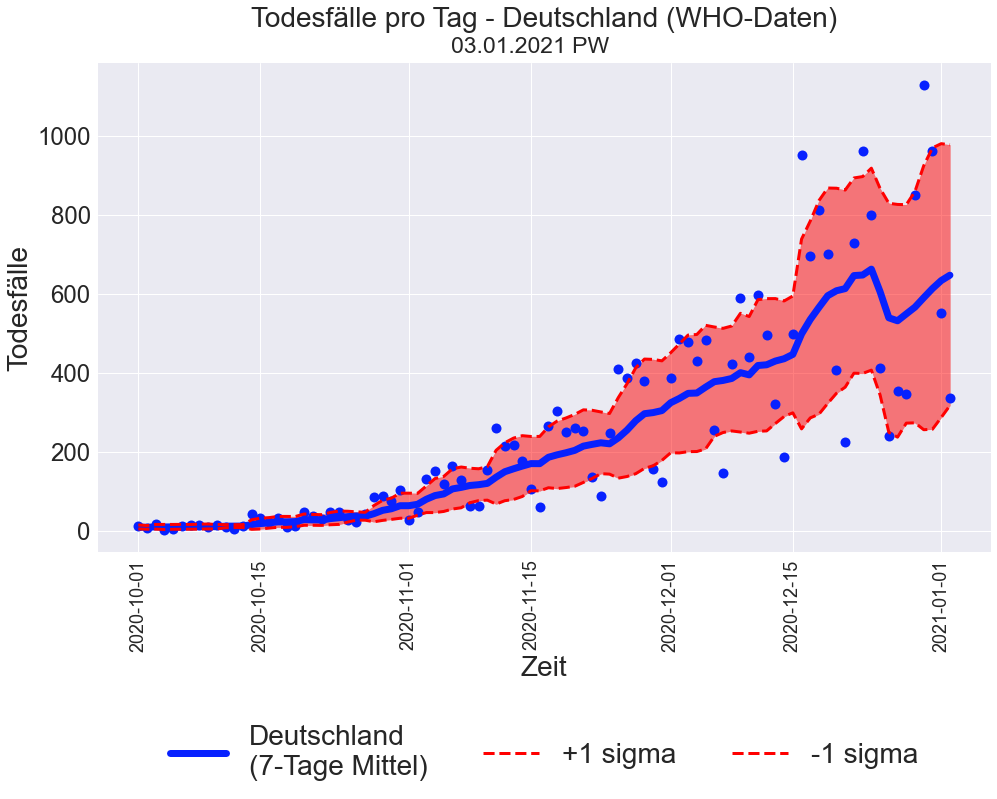

In [485]:
# Größe im 16:9 format und mit Umrechnungsfaktor 1.2 (durch Test ermittelt) für PowerPoint angepasst
plt.figure(figsize=(16,9))

plt.style.use('seaborn')
plt.grid(True)

# Todesfälle pro 100.000 Einwohner 02.12.2020

plt.plot(ger.Date_reported,ger['MA_deaths'], color=c_ger, linestyle = 'solid', linewidth = lwb, label = "Deutschland\n(7-Tage Mittel)") # blau, linie, dick
plt.plot(ger.Date_reported,ger['New_deaths'], marker='.', linestyle='', color=c_ger, markersize = 20)

plt.plot(ger.Date_reported,ger['OTG_deaths'], color='red', linestyle = 'dashed', linewidth = lws, label ="+1 sigma")
plt.plot(ger.Date_reported,ger['UTG_deaths'], color='red', linestyle = 'dashed', linewidth = lws, label ="-1 sigma")

# Legende 
plt.legend(loc='upper center', 
           bbox_to_anchor=(0.5, -0.3),
           fancybox=True, 
           shadow=True, 
           ncol=3, 
           fontsize=size)

# Schriftgrößen x und y achsenwerte
plt.xticks(fontsize=size - 10, rotation = 90)
plt.yticks(fontsize=size -4)
plt.ylabel('Todesfälle', fontsize=size)
plt.xlabel('Zeit', fontsize=size)

plt.title('Todesfälle pro Tag - Deutschland (WHO-Daten)\n', fontsize=size)
plt.suptitle(today + ' PW', fontsize=size-5, y=0.92)

# fill area between lines
plt.fill_between(ger.Date_reported, ger['OTG_deaths'], ger['UTG_deaths'] , color='red',alpha=0.5)

# Diagramm als Bild exporieren und Auflösung definieren
plt.savefig(pfad + name_4_2, dpi = 150, bbox_inches='tight')
#plt.close()

In [486]:
df_PQ.head(1)

,Kalenderwoche 2020,Anzahl Testungen,Positiv getestet,Positivenquote
1,KW 11,127457.0,7582.0,5.9


In [487]:
y = max(df_PQ["Positivenquote"])*0.96
print(f'y = {y}')

x=(1/2)*df_PQ["Kalenderwoche 2020"].count()
print(f'x = {x}')


y = 12.48
x = 21.0


## RKI Positivenquote pro Woche

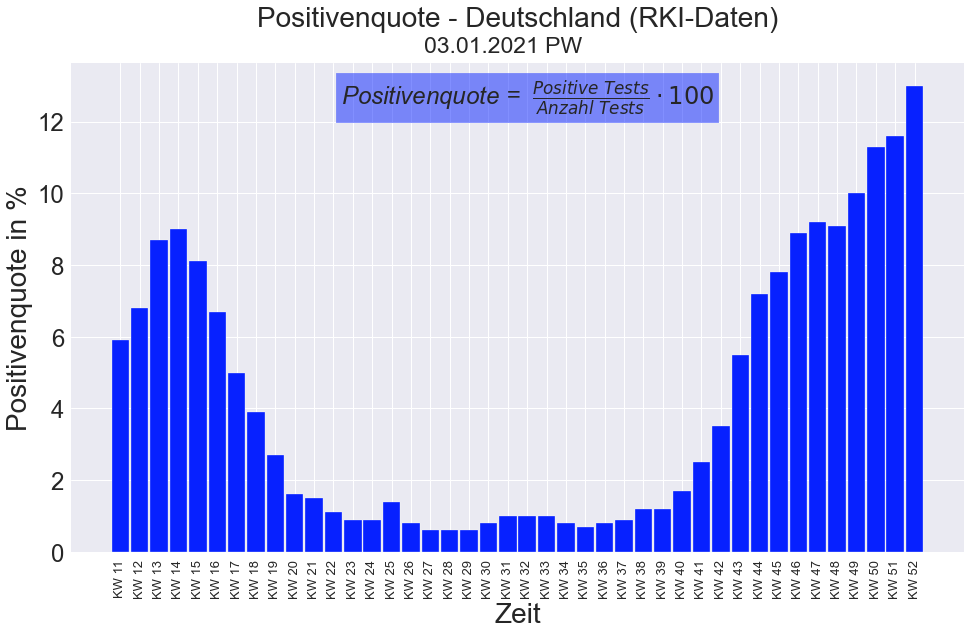

In [488]:
# Größe im 16:9 format und mit Umrechnungsfaktor 1.2 (durch Test ermittelt) für PowerPoint angepasst
plt.figure(figsize=(16,9))

plt.style.use('seaborn')

plt.bar(x=df_PQ["Kalenderwoche 2020"], height=df_PQ["Positivenquote"], width = 0.9, align = 'center', color = c_ger)

# # Schriftgrößen x und y achsenwerte
plt.xticks(fontsize=size - 15, rotation=90)
plt.yticks(fontsize=size -4)

plt.ylabel('Positivenquote in %', fontsize=size)
plt.xlabel('Zeit', fontsize=size)

plt.title('Positivenquote - Deutschland (RKI-Daten)\n', fontsize=size)
plt.suptitle(today + ' PW', fontsize=size-5, y=0.92)


plt.text(x, y, r'Positivenquote =  $\frac{Positive\ Tests}{Anzahl\ Tests}\cdot100$', horizontalalignment='center', size=size-4, style='italic',
        bbox={'facecolor': c_ger, 'alpha': 0.5, 'pad': 5})

# Diagramm als Bild exporieren und Auflösung definieren
plt.savefig(pfad + name_6, dpi = 150, bbox_inches='tight')
#plt.close()


## Testungen

In [489]:
df_PQ.head(1)

,Kalenderwoche 2020,Anzahl Testungen,Positiv getestet,Positivenquote
1,KW 11,127457.0,7582.0,5.9


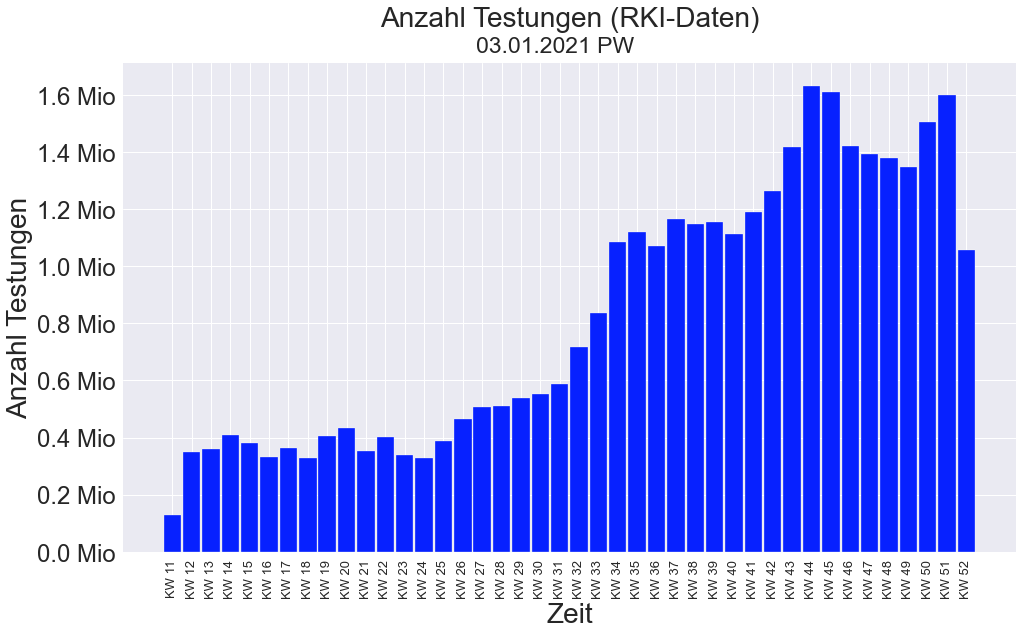

In [490]:
def millions(x, pos):
   # 'The two args are the value and tick position'
    return '%1.1f Mio' % (x * 1e-6)
formatter = FuncFormatter(millions)


fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot()
ax.yaxis.set_major_formatter(formatter)


ax = plt.bar(x=df_PQ["Kalenderwoche 2020"], height=df_PQ["Anzahl Testungen"], width = 0.9, align = 'center', color = c_ger)

# # Schriftgrößen x und y achsenwerte
plt.xticks(fontsize=size - 15, rotation=90)
plt.yticks(fontsize=size -4)


plt.ylabel('Anzahl Testungen', fontsize=size)
plt.xlabel('Zeit', fontsize=size)

plt.title('Anzahl Testungen (RKI-Daten)\n', fontsize=size)
plt.suptitle(today + ' PW', fontsize=size-5, y=0.92)

#plt.figure(figsize=(16,9))

fig.savefig(pfad + name_6_2, dpi = 150, bbox_inches='tight')

plt.show()

## Impfungen

In [491]:
# Einwohner der Bundesländer

# Datenimport Bundesländer
df_EW = pd.read_excel("D:\\Github\\Covid-19-Auswertung-WHO-DIVI\\input\\02-bundeslaender.xlsx",
                     sheet_name="Bundesländer_mit_Hauptstädten",
                     usecols="A:G",
                     skiprows=6)

# Spalten Überschriften definieren 
df_EW.rename(columns= {"Unnamed: 0": "Bundesland"},inplace=True)
df_EW.rename(columns= {"Unnamed: 1": "Stadt"},inplace=True)
df_EW.rename(columns= {"Unnamed: 2": "Fläche"},inplace=True)
df_EW.rename(columns= {"Unnamed: 3": "Einwohner"},inplace=True)
df_EW.rename(columns= {"Unnamed: 4": "Einwohner_M"},inplace=True)
df_EW.rename(columns= {"Unnamed: 5": "Einwohner_F"},inplace=True)
df_EW.rename(columns= {"Unnamed: 6": "Einwohner_pro_km²"},inplace=True)

# nicht gebrauchte columns löschen
del df_EW["Stadt"]
del df_EW["Einwohner_M"]
del df_EW["Einwohner_F"]
del df_EW["Einwohner_pro_km²"]

# Rechnen
df_EW["Einwohner_pro_km²"] = df_EW["Einwohner"]/df_EW["Fläche"]

# alles löschen was keine Bundesländer sind
df_EW["Bundesland"] = df_EW["Bundesland"].fillna("x")      # ersetze alle NaN Werte mit x
df_EW["Fläche"] = df_EW["Fläche"].fillna("x")              # ersetze alle NaN Werte mit x
indexNames = df_EW[ df_EW['Bundesland'] == "x" ].index     # alle Index Werte mit "x" in eine Variable schreiben
df_EW.drop(indexNames , inplace=True)                      # lösche diese Index rows vom dataframe
indexNames = df_EW[ df_EW['Fläche'] == "x" ].index         # wiederholen
df_EW.drop(indexNames , inplace=True)                      # wiederholen


# Bundesland erste 3 Zeichen entfernen
df_EW["Bundesland"] = df_EW["Bundesland"].str[3:]

# Datentyp in float ändern
df_EW["Fläche"] = pd.to_numeric(df_EW["Fläche"], errors='coerce')

#remove space at start
df_EW["Bundesland"] = df_EW["Bundesland"].str.lstrip()

# Datentyp in str ändern
#df_EW.Bundesland = df_EW.Bundesland.astype(str)
#df_EW.Bundesland = df_EW.Bundesland.str.encode('utf-8')

print(df_EW)

                Bundesland    Fläche   Einwohner  Einwohner_pro_km²
0       Schleswig-Holstein  15800.54   2903773.0         183.776820
2                  Hamburg    755.09   1847253.0        2446.401091
4            Niedersachsen  47709.80   7993608.0         167.546458
6                   Bremen    419.37    681202.0        1624.346043
8      Nordrhein-Westfalen  34112.44  17947221.0         526.119533
10                  Hessen  21115.64   6288080.0         297.792537
12         Rheinland-Pfalz  19858.00   4093903.0         206.158878
14       Baden-Württemberg  35747.83  11100394.0         310.519380
16                  Bayern  70541.57  13124737.0         186.056775
18                Saarland   2571.11    986887.0         383.836942
20                  Berlin    891.12   3669491.0        4117.841593
22             Brandenburg  29654.43   2521893.0          85.042707
24  Mecklenburg-Vorpommern  23295.22   1608138.0          69.032960
26                 Sachsen  18449.93   4071971.0

In [492]:
# Datenimport
# df_I = pd.read_excel("D:\\Github\\Covid-19-Auswertung-WHO-DIVI\\input\\Impfquotenmonitoring.xlsx",
#                     sheet_name=[1])

# Impfungen sheet_name der Datenquelle auslesen
df_I_sheet = pd.read_excel("D:\\Github\\Covid-19-Auswertung-WHO-DIVI\\input\\Impfquotenmonitoring.xlsx", None)
sheet_name = df_I_sheet.keys()         # Tabellenblätter Namen auslesen
sheet_name = [*sheet_name][1]          # Namen des zweiten Tabellenblattes anzeigen [*dict] dict keyword->list Index 1 anzeigen

# Datenimport Impfungen
df_I = pd.read_excel("D:\\Github\\Covid-19-Auswertung-WHO-DIVI\\input\\Impfquotenmonitoring.xlsx",
                    sheet_name = sheet_name,
                    usecols="A:G")

# nicht gebrauchte columns löschen
del df_I["Indikation nach Alter*"]
del df_I["Berufliche Indikation*"]
del df_I["Medizinische Indikation*"]
del df_I["Pflegeheim-bewohnerIn*"]

# nicht gebrauchte rows löschen
df_I.drop([16,17,18,19] , inplace=True)

df_I["Differenz zum Vortag"] = df_I["Differenz zum Vortag"].fillna(0)

#print(df_I.dtypes)   # Datentypen sind OK (float64)

# Datentyp in str und Encoding in UTF-8 ändern
#df_I.Bundesland = df_I.Bundesland.astype(str)
#df_I.Bundesland = df_I.Bundesland.str.encode('utf-8')

df_I.head(2)

,Bundesland,Impfungen kumulativ,Differenz zum Vortag
0,Baden-Württemberg,20045.0,2958.0
1,Bayern,39005.0,1050.0


In [493]:
df_I.head(1)

,Bundesland,Impfungen kumulativ,Differenz zum Vortag
0,Baden-Württemberg,20045.0,2958.0


In [494]:
df_EW.head(1)

,Bundesland,Fläche,Einwohner,Einwohner_pro_km²
0,Schleswig-Holstein,15800.54,2903773.0,183.77682


In [495]:
# VLOOKUP 
## df_EW (Fläche, Einwohner) in df_I

df_I_EW = pd.merge(df_I, df_EW, on='Bundesland', how='outer')   # how='outer','inner','left','right'
df_I_EW.head(1)

,Bundesland,Impfungen kumulativ,Differenz zum Vortag,Fläche,Einwohner,Einwohner_pro_km²
0,Baden-Württemberg,20045.0,2958.0,35747.83,11100394.0,310.51938


In [496]:
#df_I["Bundesland"]

In [497]:
#df_EW["Bundesland"]

In [498]:
# Impfquote in % pro Bundesland

df_I_EW["Impfquote [%]"] = (df_I_EW["Impfungen kumulativ"]/df_I_EW["Einwohner"])*100*(1/2)

del df_I_EW["Fläche"]
del df_I_EW["Einwohner"]
del df_I_EW["Einwohner_pro_km²"]

df_I_EW = df_I_EW.sort_values(by=['Impfquote [%]'], ascending=False)

df_I_EW

,Bundesland,Impfungen kumulativ,Differenz zum Vortag,Impfquote [%]
7,Mecklenburg-Vorpommern,11494.0,0.0,0.357370
13,Sachsen-Anhalt,11771.0,625.0,0.268159
6,Hessen,24791.0,3418.0,0.197127
2,Berlin,13137.0,2023.0,0.179003
11,Saarland,3316.0,600.0,0.168003
1,Bayern,39005.0,1050.0,0.148593
14,Schleswig-Holstein,7964.0,694.0,0.137132
4,Bremen,1741.0,0.0,0.127789
9,Nordrhein-Westfalen,33375.0,7908.0,0.092981
0,Baden-Württemberg,20045.0,2958.0,0.090290


In [559]:
x = (1/2)*df_I_EW["Bundesland"].count()
y = max(df_I_EW["Impfquote [%]"])*0.93
# print(x)
# print(y)

Impfstart = datetime.strptime('28.12.2020', '%d.%m.%Y')
Tage_seit_Impfstart = (now-Impfstart).days
print(f'Tage_seit_Impfstart = {Tage_seit_Impfstart}')   # wie lange schon geimpft wird

Summe_Impfungen = df_I_EW["Impfungen kumulativ"].sum()   # Summe Impfungen Stand heute
print(f'Summe_Impfungen = {Summe_Impfungen}')

Impfgeschwindigkeit = (1/2)*Summe_Impfungen/Tage_seit_Impfstart
print(f'Impfgeschwindigkeit = {Impfgeschwindigkeit} Mittelwert')
Impfgeschwindigkeit_gestern = (1/2)*df_I_EW["Differenz zum Vortag"].sum()
print(f'Impfgeschwindigkeit_gestern = {Impfgeschwindigkeit_gestern}')

if Impfgeschwindigkeit_gestern > Impfgeschwindigkeit:
    Impfgeschwindigkeit = (Impfgeschwindigkeit*0.2 + Impfgeschwindigkeit_gestern*0.8)
    print(f'Impfgeschwindigkeit = {Impfgeschwindigkeit} IF-Statement')

print(f'E_ger = {E_ger}')   # Einwohner Deutschland

Herdenimmun = round((1/12)*(1/30)*(E_ger*0.6)*(1/(Impfgeschwindigkeit)),1)   # grobe Schätzung Anzahl Monate bis Herdenimmun
print(f'Herdenimmun = {Herdenimmun} Jahren')

Tage_seit_Impfstart = 6
Summe_Impfungen = 188553.0
Impfgeschwindigkeit = 15712.75 Mittelwert
Impfgeschwindigkeit_gestern = 10543.5
E_ger = 83020000
Herdenimmun = 8.8 Jahren


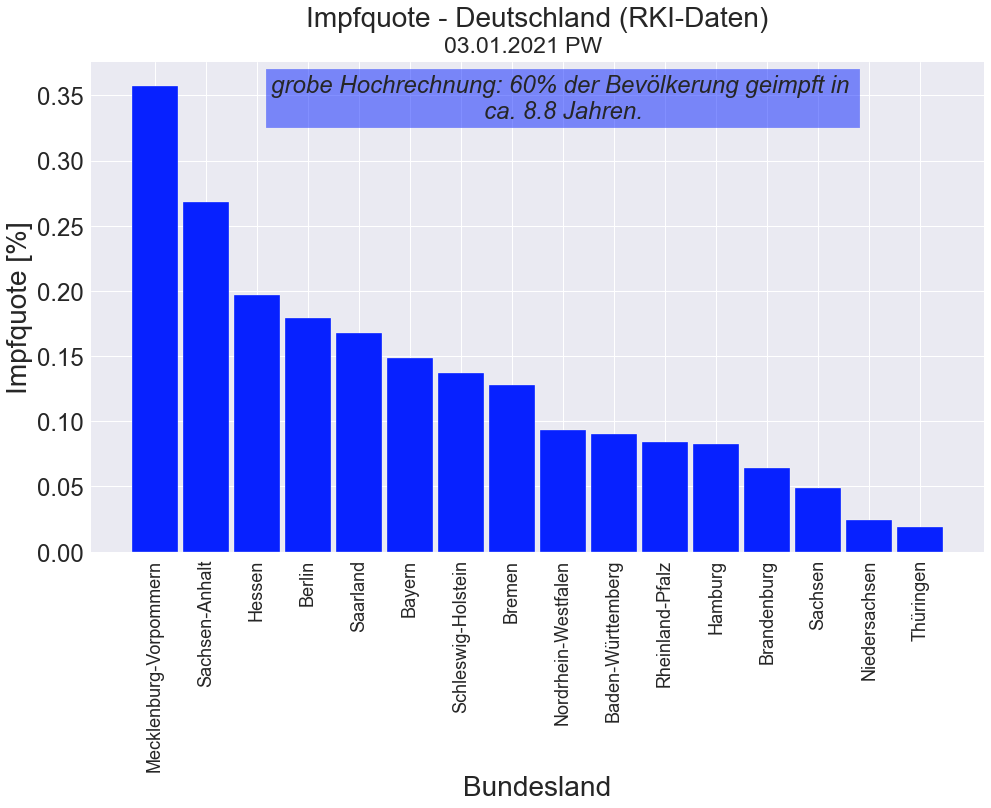

In [560]:
plt.figure(figsize=(16,9))

plt.style.use('seaborn')

plt.bar(x=df_I_EW["Bundesland"], height=df_I_EW["Impfquote [%]"], width = 0.9, align = 'center', color = c_ger)

# # Schriftgrößen x und y achsenwerte
plt.xticks(fontsize=size - 10, rotation=90)
plt.yticks(fontsize=size -4)

plt.ylabel('Impfquote [%]', fontsize=size)
plt.xlabel('Bundesland', fontsize=size)

plt.title('Impfquote - Deutschland (RKI-Daten)\n', fontsize=size)
plt.suptitle(today + ' PW', fontsize=size-5, y=0.92)

plt.text(x, y, f'grobe Hochrechnung: 60% der Bevölkerung geimpft in \nca. {Herdenimmun} Jahren.', 
        horizontalalignment='center', 
        size=size-4, 
        style='italic',
        bbox={'facecolor': c_ger, 'alpha': 0.5, 'pad': 5})

# plt.text(x, y*0.89, r'Impfquote =  $\frac{1}{2}\cdot\frac{Impfungen}{Einwohner}\cdot100$', 
#         horizontalalignment='center', 
#         size=size-4, 
#         style='italic',
#         bbox={'facecolor': c_ger, 'alpha': 0.5, 'pad': 5})

# Diagramm als Bild exporieren und Auflösung definieren
plt.savefig(pfad + name_7, dpi = 150, bbox_inches='tight')

plt.show()

## RKI Ausbruchdaten

In [501]:
# # Daten einlesen Excel - Ausbruchsdaten
# df_AB = pd.read_excel("D:\Github\Covid-19-Auswertung-WHO-DIVI\Data\Ausbruchsdaten.xlsx;jsessionid=F348B3B6878DF2812C1DF10FACEB13F4.xlsx",
#                      sheet_name ="Ausbruch_MW_D_ab2Faelle")
# #                       usecols=,
# #                       skiprows=,
# df_AB.head(1)

## RKI Altersdaten

In [502]:
#df_AB["Meldewoche"].tail(1)

## dataframe speichern

In [503]:
data.to_csv(r'D:\\Github\\Covid-19-Auswertung-WHO-DIVI\\output\\data_WHO_data.csv', index=False)

## Performance messen

In [504]:
# performance
# pc = os.environ['COMPUTERNAME']
# now2 = datetime.now()
# print(f'performance {pc} = {now2-now} seconds')

In [505]:
# Performance
pc = os.environ['COMPUTERNAME']
now2 = datetime.now()

x = now2 - now
x = round(x.total_seconds(),2)

In [506]:
# Performance CSV einlesen
d = pd.read_csv('D:\\Github\\Covid-19-Auswertung-WHO-DIVI\\input\\df_performance_Führungskreis.csv')

In [507]:
# Neues Dateframe für die Performance definieren
now = datetime.now()

d2 = {'Date': [now],
      'PC': [pc],
      'Laufzeit_in_s': [x]}
#d2

In [508]:
# Datum Spalte formatieren
df2 = pd.DataFrame(d2)
df2['Date'] = df2['Date'].dt.strftime('%Y-%m-%d %r')

In [509]:
# Performance mit dem CSV verbinden
d = d.append(df2, ignore_index=True)
#d.head(3)

In [510]:
# Datenexport Performance
d.to_csv(r'D:\\Github\\Covid-19-Auswertung-WHO-DIVI\\output\\df_performance_Führungskreis.csv', index=False)

In [511]:
# Plot Performance
sns.set(rc={'figure.figsize':(16,9)})
sns_plot = sns.distplot(d['Laufzeit_in_s'],
            kde=True,
            rug=True,
            )
sns_plot.set_title('Performance distribution',size=size)
sns_plot.set_ylabel('Wahrscheinlichkeit', size = size -5)
sns_plot.set_xlabel('Laufzeit [s]', size = size -5)
fig = sns_plot.get_figure()
fig.savefig(pfad + name_5) 
plt.close()
print(f'performance {pc} = {x} seconds')

performance DOUG = 8.35 seconds
